In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et
from matplotlib import interactive
interactive(True)
import requests
from math import radians, cos, sin, asin, sqrt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

https://www.strava.com/oauth/authorize?client_id=56464&response_type=code&redirect_uri=http://localhost:8000/GPX.html&scope=activity:read_all,read_all


In [85]:
activities = []
client_secret = 'c69c6b35d9596089e00980379f82b1e3b16d0283'
client_id = '56464'
response_type = 'code'
access_token = ""

code = '830c50e891accc6501661b9ac002bb32ec830627' #paste code here 

In [86]:
def authorize(code):
    if len(code) == 0:
        return 
    auth_link = "https://www.strava.com/oauth/token"
    headers = {'Accept': 'application/json, text/plain, */*', 'Content-Type' : 'application/json'}
    body = {
        'client_id' : client_id,
        'client_secret' : client_secret,
        'grant_type' : 'authorization_code',
        'code' : code
    }
    res = requests.post(auth_link, data=body).json()
    return res

access_token = authorize(code)
token = access_token["access_token"]

In [87]:
def get_activities():
    if not activities:
        link = "https://www.strava.com/api/v3/athlete/activities?per_page=70&access_token=" + token
        headers = {'Accept': 'application/json, text/plain, */*', 'Content-Type' : 'application/json'}
        res = requests.get(link)
        return res.json()
    else:
        return activities
if not activities:
    activities = get_activities()
filtered = list(filter(lambda a : "2020-05" in a["start_date"], activities))
filtered[1]["id"]

3532758896

In [88]:
def get_stream(activity_id):
    keys = "latlng,altitude,distance,distance,velocity_smooth,grade_smooth,cadence"
    url = "https://www.strava.com/api/v3/activities/%s/streams?key_by_type=true&keys=%s&access_token=%s" % (activity_id, keys,token)
    res = requests.get(url)
    print(url)
    return res.json()
stream = get_stream(filtered[0]['id'])

https://www.strava.com/api/v3/activities/3532759237/streams?key_by_type=true&keys=latlng,altitude,distance,distance,velocity_smooth,grade_smooth,cadence&access_token=1d0e8b5f1db853dd60fea7e044b1951147a7c65a


In [89]:
df = pd.DataFrame(data={
    "alt" : stream["altitude"]["data"], 
    "latlng" : stream["altitude"]["data"],
    "velocity" : stream["velocity_smooth"]["data"],
    "cadence" : stream["cadence"]["data"],
    "grade" : stream["grade_smooth"]["data"],
    "dist" : stream["distance"]["data"]
})
df["up or down"] = (df["grade"] >= 0).astype(int)
df.head()

,alt,latlng,velocity,cadence,grade,dist,up or down
0,34.1,34.1,0.0,0,0.0,1.1,1
1,34.1,34.1,1.3,57,-0.4,3.8,0
2,34.1,34.1,2.7,83,-0.7,25.7,0
3,33.9,33.9,3.4,81,-1.4,47.6,0
4,33.6,33.6,3.6,82,-5.8,69.3,0


In [90]:
model = LogisticRegressionCV(cv = 6, max_iter = 1000)

train, test = train_test_split(df, test_size=0.1, random_state=42)
X_train = train[["velocity", "dist", "cadence"]]
Y_train = train["up or down"]

model.fit(X_train, Y_train)
model.score(X_train, Y_train)

0.8032786885245902

In [91]:
X_test = test[["velocity", "dist", "cadence"]]
Y_test = test["up or down"]
model.score(X_test, Y_test)

0.8529411764705882

In [132]:
linear_model = LinearRegression()
df = df[df["cadence"] > 10]
X = df[["cadence", "grade"]]
Y = df["velocity"]
cadence = np.linspace(min(df["cadence"]), max(df["cadence"]), 30)
grade = np.linspace(min(df["grade"]), max(df["grade"]), 30)
x_meshed, y_meshed = np.meshgrid(cadence, grade)
linear_model.fit(X, Y)
Y_hat = linear_model.predict(pd.DataFrame({'x' : x_meshed.ravel(), 'y': y_meshed.ravel()}))
linear_model.coef_, linear_model.intercept_

(array([ 0.10969977, -0.04762796]), -5.3758436946989265)

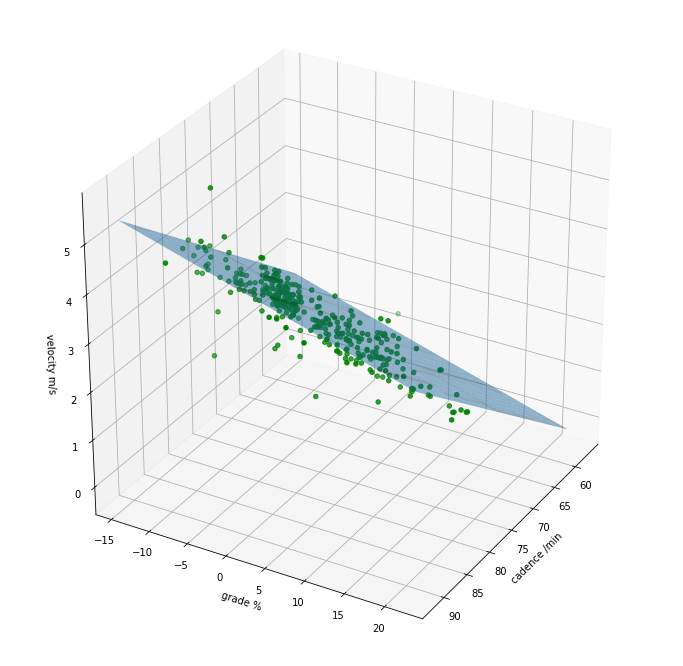

In [139]:
plt3d = plt.figure(figsize=(12,12)).gca(projection='3d')

# Ensure that the next plot doesn't overwrite the first plot
ax = plt.gca()
#ax.hold(True)

plt3d.scatter(df["cadence"], df["grade"], Y, color='green')
plt3d.plot_surface(x_meshed, y_meshed, Y_hat.reshape(x_meshed.shape), alpha=0.5)
plt.xlabel("cadence /min")
plt.ylabel("grade %")
ax.set_zlabel("velocity m/s")

ax.view_init(30, 30)

### Get data locally

In [3]:

xtree = et.parse("data/Lunch_Run_Berk.gpx")
xroot = xtree.getroot()

trk = xroot[1]
trkseg = trk[2]

cols = ["lat", "lon", "elev", "time"]
rows = []
for data_packet in trkseg:
    rows.append({"lat" : float(data_packet.attrib.get('lat')),
                    "lon" : float(data_packet.attrib.get('lon')),
                    "elev" : float(data_packet[0].text), #elev
                    "time" : data_packet[1].text}) #time
df_granular = pd.DataFrame(rows, columns = cols)
df_granular["time"] = pd.to_datetime(df_granular["time"])
df_granular.head()

,lat,lon,elev,time
0,37.866819,-122.260459,73.0,2019-03-22 19:09:37+00:00
1,37.866819,-122.260459,73.0,2019-03-22 19:09:50+00:00
2,37.866708,-122.260376,73.3,2019-03-22 19:09:54+00:00
3,37.866783,-122.260154,73.6,2019-03-22 19:10:00+00:00
4,37.866712,-122.260032,73.8,2019-03-22 19:10:02+00:00


In [4]:
df = df_granular
# drop_indices = [i for i in range(len(df)) if i % 4 != 0]
# df = df.drop(index=drop_indices)
# df.head()

In [5]:
#add speed and grade column

df["lat rad"], df["lon rad"] = df["lat"].apply(radians), df["lon"].apply(radians)
change_lat = df["lat rad"] - df["lat rad"].shift()
change_lon = df["lon rad"] - df["lon rad"].shift()
change_time = df["time"] - df["time"].shift()

change_time[1:] = change_time[1:].dt.total_seconds().astype(int)

#haversine forumla
a = (change_lat/2).apply(sin)**2 + df["lat rad"].shift().apply(cos) * df["lat rad"].apply(cos) * (change_lon/2).apply(sin)**2
c = 2 * a.apply(sqrt).apply(asin)
r = 3956#6371 for km # Radius of earth in kilometers. Use 3956 for miles
df["distance miles"] = c * r

df["distance feet"] = df["distance miles"] * 5280
# factor = 1 mile / distance_miles --> pace = time_seconds * factor / 60
df["pace"] = df["distance miles"] ** (-1) * change_time / 60
df.head(20)

,lat,lon,elev,time,lat rad,lon rad,distance miles,distance feet,pace
0,37.866819,-122.260459,73.0,2019-03-22 19:09:37+00:00,0.660901,-2.133848,NaN,NaN,NaT
1,37.866819,-122.260459,73.0,2019-03-22 19:09:50+00:00,0.660901,-2.133848,0.000000,0.000000,inf
2,37.866708,-122.260376,73.3,2019-03-22 19:09:54+00:00,0.660899,-2.133846,0.008900,46.990390,7.49089
3,37.866783,-122.260154,73.6,2019-03-22 19:10:00+00:00,0.660900,-2.133842,0.013162,69.495645,7.5976
4,37.866712,-122.260032,73.8,2019-03-22 19:10:02+00:00,0.660899,-2.133840,0.008262,43.620721,4.03478
5,37.866701,-122.259941,74.0,2019-03-22 19:10:04+00:00,0.660899,-2.133839,0.005018,26.494821,6.64281
6,37.866654,-122.259623,74.5,2019-03-22 19:10:10+00:00,0.660898,-2.133833,0.017634,93.109799,5.67072
7,37.866700,-122.259567,74.7,2019-03-22 19:10:11+00:00,0.660899,-2.133832,0.004405,23.258765,3.78352
8,37.866719,-122.259525,74.8,2019-03-22 19:10:12+00:00,0.660899,-2.133831,0.002639,13.931463,6.31664
9,37.866778,-122.259287,75.6,2019-03-22 19:10:17+00:00,0.660900,-2.133827,0.013597,71.793520,6.12869


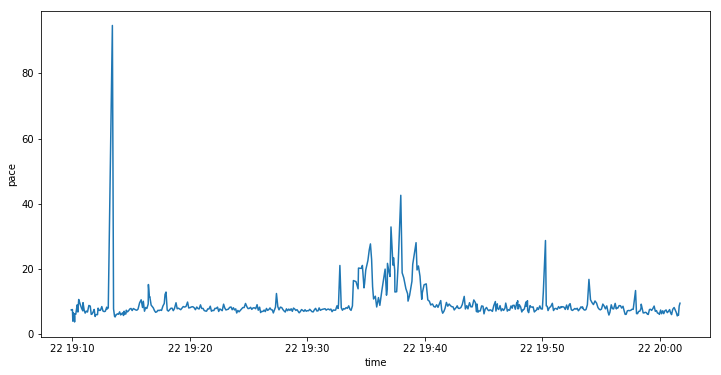

In [166]:
plt.figure(figsize = (12, 6))

plt.plot(df["time"][2:], df["pace"][2:])
plt.xlabel("time")
plt.ylabel("pace")

plt.show()

In [168]:
np.mean(df["pace"][2:])

9.158062155884437